## Imports

In [1]:
import torch, torchvision
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from matplotlib import pyplot as plt 

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Load the CIFAR-10 dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
testset = datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)

batch_size = 64
# You should use as many cores you have on your laptop
num_workers = 8

# Fill in the options for both data loaders. Warning: the training dataloader should shuffle the data
trainloader = torch.utils.data.DataLoader(trainset, num_workers=num_workers, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, num_workers=num_workers, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize the Images of CIFAR-10

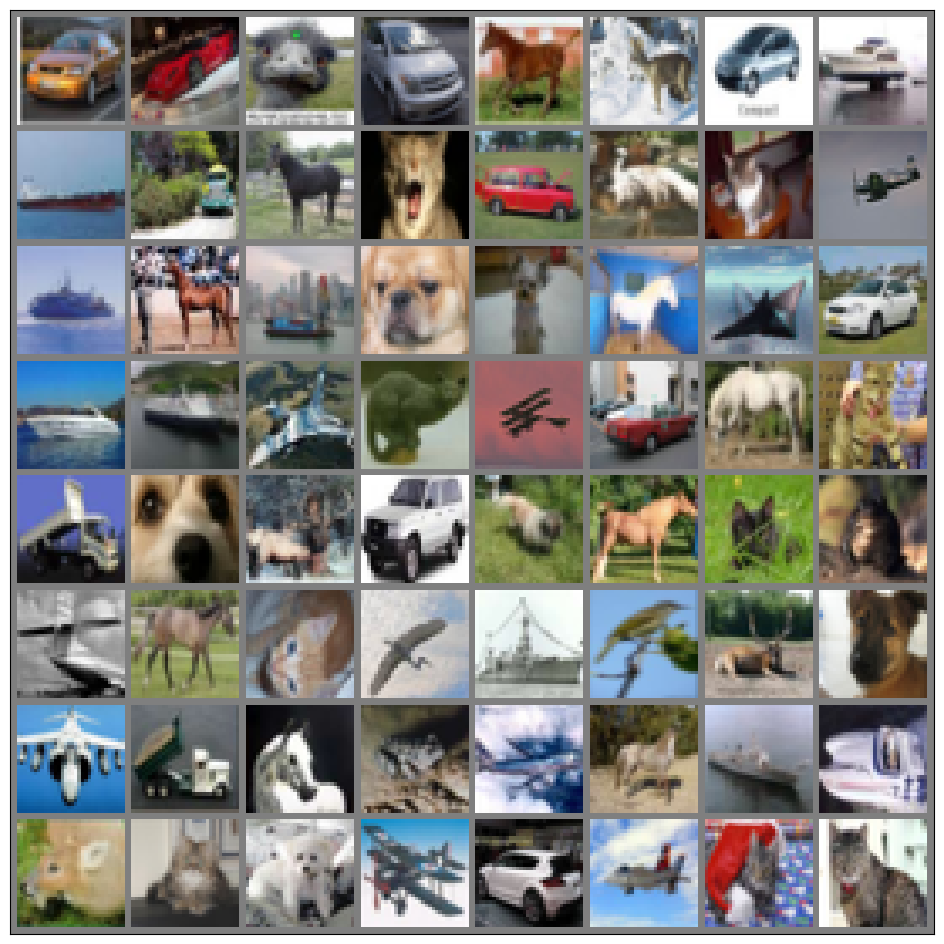

  car   car  bird   car horse  deer   car  ship  ship truck horse   cat   car  bird   cat plane  ship horse  ship   dog   dog horse plane   car  ship  ship plane   cat plane   car horse   cat truck   dog  deer   car   dog horse   cat  frog plane horse   cat  bird  ship  bird  deer   dog plane truck horse  frog plane horse  ship  ship  deer   cat   dog plane   car plane   cat   cat


In [3]:
def show_images(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Creating a MLP model and train it

### Hyperparameters

In [9]:
input_dim = 32 * 32 * 3
hidden_dim = 1024
output_dim = len(classes)
learning_rate = 0.001
num_epochs = 128

### Network Architecture

- You need to implement multi-layer perceptron for the problem of classifying CIFAR-10 images
- You will also have to define the forward pass yourself.

In [10]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(-1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Create the Network

- You are now ready to create your neural network object
- You will also have to define an appropriate loss function to minimize and an optimization algorithm
- By default, you can use the cross-entropy loss and the adam optimizer

In [11]:
model = Net(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.89)

### Train the Network

- Once you have your neural network you just need to train it. 
- You will have to compute the output of the forward pass, compare it to your desired output and update the parameters of the network by backpropagation. 

In [12]:
from tqdm import tqdm

def train(num_epochs):
    for i in tqdm(range(num_epochs)):
        for inputs, targets in trainloader:
            model.train(True)
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = F.cross_entropy(outputs, targets)

            print(f"Epoch {i + 1}, Loss: {loss.item():.4f}", end="\r")

            loss.backward()
            optimizer.step()


In [13]:
train(num_epochs)

  0%|          | 0/128 [00:00<?, ?it/s]

## Evaluate the final performance of the Network

- Once you think your network is properly trained, you will test its performance on the testing-set of the CIFAR-10 dataset
- Compute the final accuracy of your model
- You should be able to reach a 50% accuracy with a simple multi-layer perceptron

In [99]:
def test(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, targets in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy:.2f}%")

In [100]:
test(model, testloader)

Accuracy on the test set: 10.00%
